In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian


In [2]:
import arviz as az
import jax.numpy as jnp
import jax.random as random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpyro.infer import MCMC, NUTS
import numpyro_glm
import numpyro_glm.metric.models as glm_metric

# Chapter 17: Metric Predicted Variable with one Metric Predictor

## Simple Linear Regression

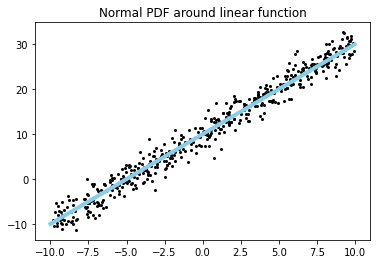

In [3]:
x = np.random.uniform(-10, 10, size=500)
y = np.random.normal(10 + 2 * x, 2)

fig, ax = plt.subplots()
ax.scatter(x, y, c='black', s=4)
ax.set_title('Normal PDF around linear function')

xline = np.linspace(-10, 10, 1000)
ax.plot(xline, 10 + 2 * xline, lw=4, c='#87ceeb')

# TODO
for xinterval in [-7.5, -2.5, 2.5, 7.5]:
    y_ = np.linspace(xinterval - 6, xinterval + 6, 1000)

## Robust Linear Regression

In [4]:
height_weight_30_data = pd.read_csv('datasets/HtWtData30.csv')
height_weight_30_data.describe()

,male,height,weight
count,30.000000,30.000000,30.000000
mean,0.466667,66.983333,154.013333
std,0.507416,4.201074,31.702570
min,0.000000,57.500000,96.500000
25%,0.000000,64.100000,128.850000
50%,0.000000,66.450000,147.900000
75%,1.000000,69.575000,179.650000
max,1.000000,76.000000,215.100000


We will test the model with raw data (no standardization applied to both y and x).

In [5]:
mcmc_key = random.PRNGKey(0)
kernel = NUTS(glm_metric.one_metric_predictor_robust_no_standardization)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000)
mcmc.run(
    mcmc_key,
    jnp.array(height_weight_30_data.height.values),
    jnp.array(height_weight_30_data.weight.values),
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     48.74      3.77     48.95     42.64     54.86   6623.14      1.00
        b1      0.12      0.02      0.12      0.08      0.16   6680.64      1.00
        nu     23.41     25.54     14.07      1.04     56.22   7959.41      1.00
     sigma      3.56      0.74      3.51      2.36      4.75   6747.45      1.00

Number of divergences: 0


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

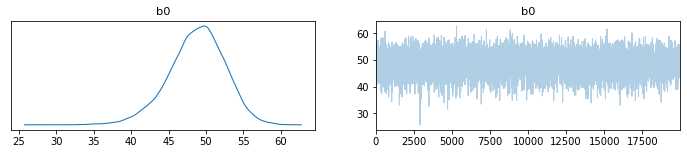

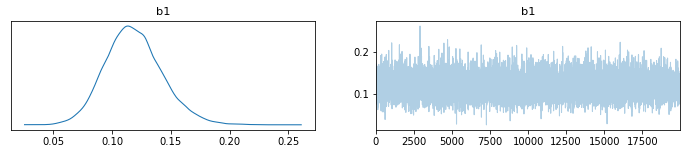

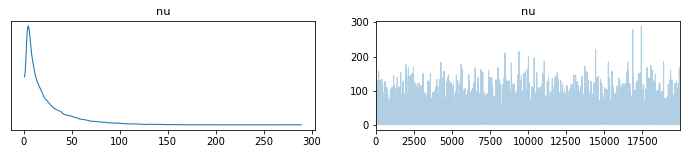

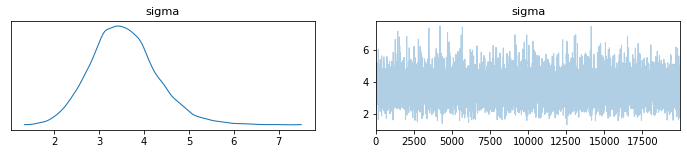

In [6]:
numpyro_glm.plot_diagnostic(mcmc, ['b0', 'b1', 'nu', 'sigma'])

Here is the model with both y and x standardized.

In [7]:
mcmc_key = random.PRNGKey(0)
kernel = NUTS(glm_metric.one_metric_predictor_robust)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000)
mcmc.run(
    mcmc_key,
    jnp.array(height_weight_30_data.height.values),
    jnp.array(height_weight_30_data.weight.values),
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        nu     28.71     28.03     19.49      1.29     65.75  16410.73      1.00
       zb0      0.03      0.17      0.03     -0.25      0.29  18403.15      1.00
       zb1      0.58      0.18      0.58      0.28      0.86  17045.69      1.00
    zsigma      0.84      0.15      0.83      0.59      1.08  12277.06      1.00

Number of divergences: 0


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

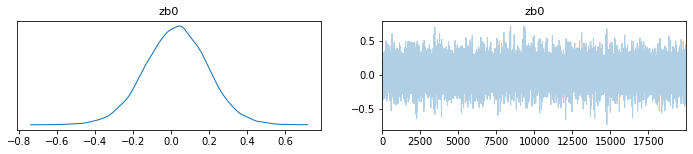

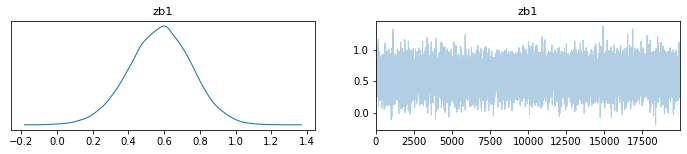

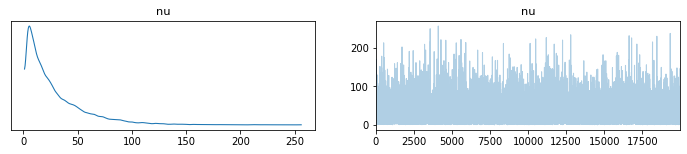

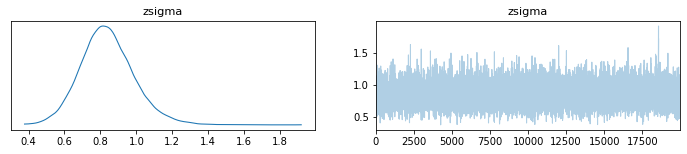

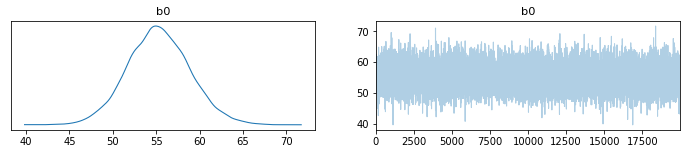

In [8]:
numpyro_glm.plot_diagnostic(mcmc, ['zb0', 'zb1', 'nu', 'zsigma', 'b0'])

## Hierarchical Regression on Individuals within Groups

In [9]:
hier_linear_reg_data = pd.read_csv('datasets/HierLinRegressData.csv')
hier_linear_reg_data['Subj'] = hier_linear_reg_data['Subj'].astype('category')
hier_linear_reg_data.describe()

,X,Y
count,132.000000,132.000000
mean,67.084848,153.328788
std,7.146830,32.041570
min,49.100000,70.000000
25%,62.500000,131.300000
50%,66.250000,153.600000
75%,71.400000,172.550000
max,86.200000,240.400000


In [10]:
mcmc_key = random.PRNGKey(0)
kernel = NUTS(glm_metric.hierarchical_one_metric_predictor_multi_groups_robust)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000)
mcmc.run(
    mcmc_key,
    jnp.array(hier_linear_reg_data.Y.values),
    jnp.array(hier_linear_reg_data.X.values),
    jnp.array(hier_linear_reg_data.Subj.cat.codes.values),
    hier_linear_reg_data.Subj.cat.categories.size,
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        nu     40.26     31.85     31.15      3.30     82.83  20041.59      1.00
   zb0_[0]      0.67      0.34      0.66      0.11      1.22   7131.44      1.00
   zb0_[1]      1.07      0.36      1.06      0.47      1.66   5926.11      1.00
   zb0_[2]     -0.70      0.36     -0.69     -1.28     -0.12   7002.25      1.00
   zb0_[3]      0.65      0.44      0.64     -0.09      1.35  10229.08      1.00
   zb0_[4]     -0.73      0.38     -0.72     -1.34     -0.12   7992.27      1.00
   zb0_[5]     -2.17      0.49     -2.14     -2.93     -1.35   6327.48      1.00
   zb0_[6]     -0.14      0.41     -0.14     -0.83      0.51  10582.32      1.00
   zb0_[7]     -0.20      0.32     -0.20     -0.73      0.34   7636.92      1.00
   zb0_[8]     -0.56      0.34     -0.55     -1.11      0.00   7479.22      1.00
   zb0_[9]     -1.28      0.39     -1.27     -1.91     -0.64   6051.55      1.00
  zb0_[10]      0.73      0

## Quadratic Trend and Weighted Data

In [11]:
income_data_3yr = pd.read_csv('datasets/IncomeFamszState3yr.csv', skiprows=1)
income_data_3yr['State'] = income_data_3yr['State'].astype('category')
income_data_3yr.describe()

,FamilySize,MedianIncome,SampErr
count,312.000000,312.000000,312.000000
mean,4.500000,66824.772436,2590.810897
std,1.710569,14774.402348,2410.533770
min,2.000000,18860.000000,240.000000
25%,3.000000,57346.500000,1001.500000
50%,4.500000,65097.000000,1805.000000
75%,6.000000,73992.750000,3297.750000
max,7.000000,124167.000000,15121.000000


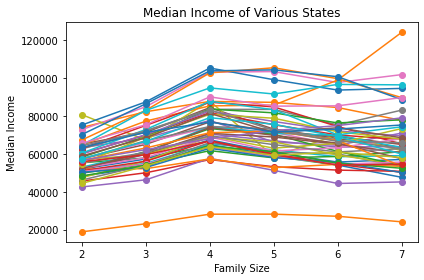

In [12]:
fig, ax = plt.subplots()

for state in income_data_3yr['State'].unique():
    state_data = income_data_3yr[income_data_3yr['State'] == state]
    state_data = state_data.sort_values('FamilySize')

    ax.plot(state_data['FamilySize'], state_data['MedianIncome'], 'o-')

ax.set_title('Median Income of Various States')
ax.set_xlabel('Family Size')
ax.set_ylabel('Median Income')
fig.tight_layout()

In [13]:
mcmc_key = random.PRNGKey(0)
kernel = NUTS(
    glm_metric.hierarchical_quadtrend_one_metric_predictor_multi_groups_robust)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=10000)
mcmc.run(
    mcmc_key,
    jnp.array(income_data_3yr['MedianIncome'].values),
    jnp.array(income_data_3yr['FamilySize'].values),
    jnp.array(income_data_3yr['State'].cat.codes.values),
    income_data_3yr['State'].cat.categories.size,
    jnp.array(income_data_3yr['SampErr'].values),
)
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   b0_z_[0]     -0.79      0.24     -0.80     -1.17     -0.39   2406.14      1.00
   b0_z_[1]      1.15      0.28      1.14      0.70      1.61   2580.15      1.00
   b0_z_[2]     -0.75      0.21     -0.75     -1.10     -0.41   1958.39      1.00
   b0_z_[3]     -1.19      0.22     -1.18     -1.53     -0.81   2062.95      1.00
   b0_z_[4]     -0.08      0.27     -0.11     -0.53      0.37   1888.94      1.00
   b0_z_[5]      0.31      0.24      0.30     -0.07      0.71   1969.59      1.00
   b0_z_[6]      1.93      0.34      1.92      1.37      2.48   2764.33      1.00
   b0_z_[7]      0.70      0.27      0.70      0.26      1.14   2900.77      1.00
   b0_z_[8]      0.22      0.45      0.21     -0.53      0.93   7611.55      1.00
   b0_z_[9]     -0.71      0.21     -0.71     -1.07     -0.38   1892.05      1.00
  b0_z_[10]     -0.67      0.22     -0.68     -1.03     -0.31   2099.65      1.00
  b0_z_[11]    

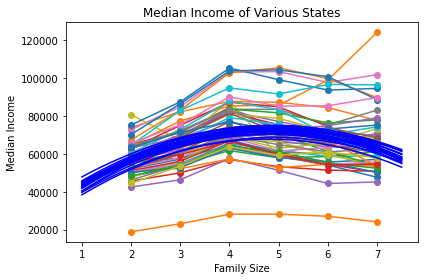

In [14]:
def choose_credible_parabola_parameters(idata, hdi=0.95, *, a='b0', b='b1', c='b2', n_curves=20, dim=None):
    """
    Plot credible parabola ax^2 + bx + c = 0. 
    """
    def is_between(values, low, high):
        return (values >= low) & (values <= high)

    posterior = idata.posterior
    hdi_posterior = az.hdi(posterior, hdi_prob=hdi)

    a_posterior = posterior[a].sel(dim).values.flatten()
    b_posterior = posterior[b].sel(dim).values.flatten()
    c_posterior = posterior[c].sel(dim).values.flatten()

    # Choose only parameters in the specified HDI.
    amask_in_hdi = is_between(a_posterior, *hdi_posterior[a].sel(dim).values)
    bmask_in_hdi = is_between(b_posterior, *hdi_posterior[b].sel(dim).values)
    cmask_in_hdi = is_between(c_posterior, *hdi_posterior[c].sel(dim).values)
    params_in_hdi = amask_in_hdi & bmask_in_hdi & cmask_in_hdi
    idx_in_hdi = np.arange(len(posterior.chain) *
                           len(posterior.draw))[params_in_hdi.flatten()]

    # Then, randomly choose from these parameters to plot the results.
    for idx in np.random.choice(idx_in_hdi, n_curves, replace=False):
        aval = a_posterior[idx]
        bval = b_posterior[idx]
        cval = c_posterior[idx]

        yield aval, bval, cval


idata = az.from_numpyro(
    mcmc,
    coords=dict(state=np.arange(len(income_data_3yr['State'].cat.categories))),
    dims=dict(b0=['state'], b1=['state'], b2=['state'],
              b0_z=['state'], b1_z=['state'], b2_z=['state'],),
)

n_posterior_curves = 20
x = np.linspace(1, 7.5, 1000)

for b0_mean, b1_mean, b2_mean in choose_credible_parabola_parameters(
        idata, a='b0_mean', b='b1_mean', c='b2_mean', n_curves=n_posterior_curves):
    ax.plot(x, b0_mean + b1_mean * x + b2_mean * x**2, c='b')

fig

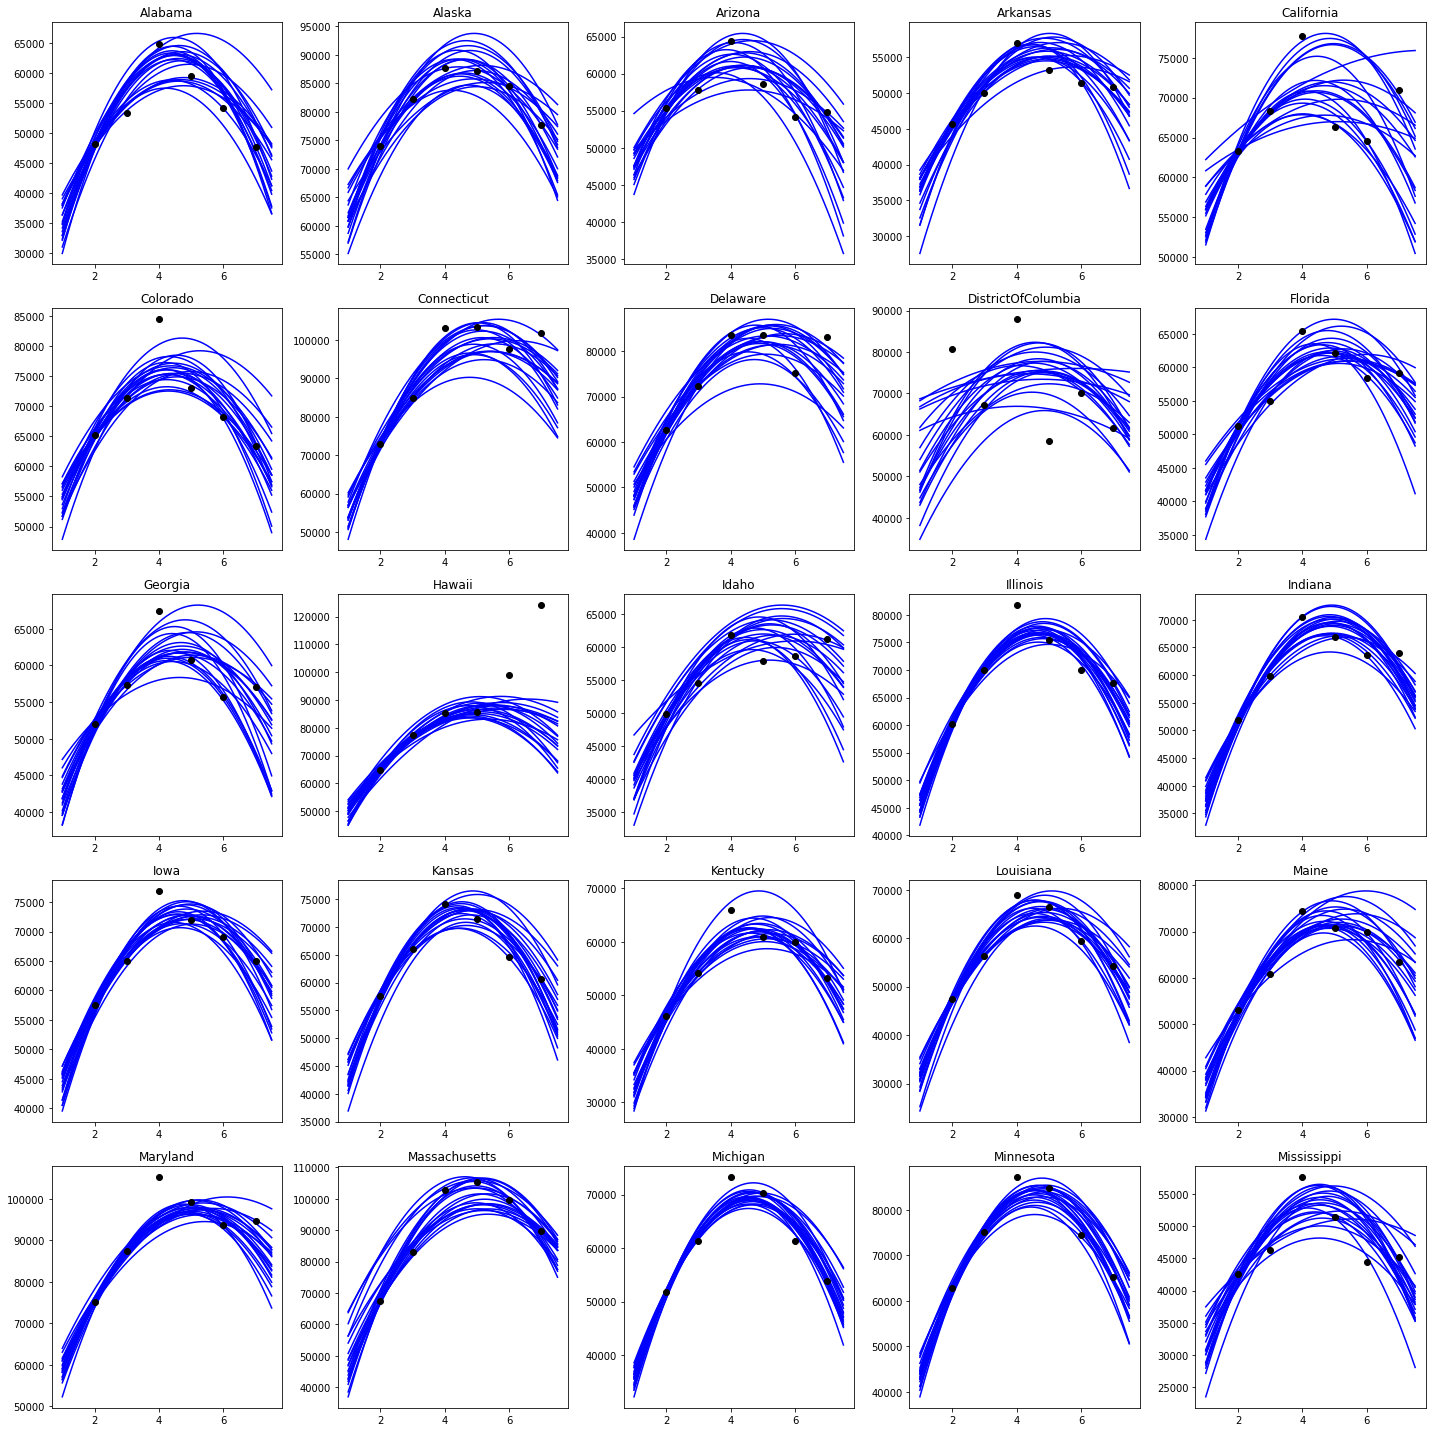

In [15]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

for state_idx, state, ax in zip(range(income_data_3yr['State'].cat.categories.size),
                                income_data_3yr['State'].cat.categories,
                                axes.flatten()):
    # Plot posterior curves.
    for b0, b1, b2 in choose_credible_parabola_parameters(idata, a='b0', b='b1', c='b2', dim=dict(state=state_idx)):
        ax.plot(x, b0 + b1 * x + b2 * x**2, c='b')

    # Superimpose state median income.
    state_data = income_data_3yr[income_data_3yr['State'] == state]
    state_data = state_data.sort_values('FamilySize')
    ax.plot(state_data['FamilySize'], state_data['MedianIncome'], 'ko')

    ax.set_title(state)

fig.tight_layout()